In [94]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from torch.distributions.utils import logits_to_probs

from sklearn import linear_model
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import ClippedAdam
from pyro.nn import PyroModule, PyroSample

from src.utils import load_data

### Load data

In [95]:
X, y, _ = load_data(impute=True)
print(X.columns)
X = X.values
y = y.values
print('X-shape: {}, y-shape: {}'.format(X.shape, y.shape)) 

Index(['youth_pop_5to18', 'commute_priv_vehicle', 'med_hhincome',
       'avg_ann_daily_traffic', 'fragment_index', 'TotalPop', 'Men', 'Women',
       'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Citizen', 'Income',
       'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')
X-shape: (2095, 38), y-shape: (2095,)


##### Prepare data for model.

In [96]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [97]:
# Get indeces for dividing data into training and test set.
train_perc = 0.8 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]

In [98]:
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 1676
num test: 419


##### Baseline linear regression

In [99]:
# create and fit regression model
lreg = linear_model.LinearRegression()
lreg.fit(X_train, y_train)

# make predictions for test set
y_hat_lreg = lreg.predict(X_test)
print("first 5 predictions:", y_hat_lreg[:5])
print("first 5 true values:", y_test[:5])

# evaluate prediction accuracy
print("MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

first 5 predictions: [ 7.26861953  9.678664   14.4990407  16.77358419  2.86162716]
first 5 true values: [ 2  3 12 15  7]
MSE: 36.2986428487728


#### Neural Network

Let $\textbf{X}_n$ denote the characteristics of the n'th area. We now split the characteristics into a set of inputs for our linear term, $\textbf{X}'_n$ and a set of inputs for our non-linear term, $\textbf{X}^*_n$, such that
$$
\psi_n = \beta^T\textbf{X}'_n+f_{\text{nnet}}(\textbf{X}^*_n)+\phi_n.
$$

#### PGM
![image info](./neural_net_pgm.jpg)


#### Generative Process

<ol>
    <li> Set hyperparameter $r$. </li>

   <li> Draw non-linear coefficients for neural net $\theta \sim N(\theta|\textbf{0},\tau \textbf{I})$</li>
    <li> For the i'th observation </li>
    <ol>
        <li> Draw $y_n \sim \text{NB}(r, f_{\text{nnet}}(\textbf{X}^*_n))$</li>
    </ol>
</ol>

In [103]:
def nn_model(X, obs=None, pred=False):
    # Number of observations
    N, n_feat = X.shape
    
    # Hyperparameters
    r_gamma1 = 5
    r_gamma2 = 2
    sigma_gamma = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2).to_event())
    sigma = pyro.sample("sigma", dist.HalfCauchy(sigma_gamma).to_event())
    
    # Artificial neural network parameters
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(n_feat, 8), torch.ones(n_feat, 8)).to_event())
    b1 = pyro.sample("b1", dist.Normal(torch.zeros(8), torch.ones(8)).to_event())
    w2 = pyro.sample("w2", dist.Normal(torch.zeros(8, 4), torch.ones(8, 4)).to_event())
    b2 = pyro.sample("b2", dist.Normal(torch.zeros(4), torch.ones(4)).to_event())
    w3 = pyro.sample("w3", dist.Normal(torch.zeros(4, 1), torch.ones(4, 1)).to_event())
    b3 = pyro.sample("b3", dist.Normal(torch.zeros(1), torch.ones(1)).to_event())
    
    with pyro.plate("data", N):
        # Draw for observations.
        # NN forward pass
        x_nn = torch.tanh(torch.matmul(X, w1) + b1)
        x_nn = torch.tanh(torch.matmul(x_nn, w2) + b2)
        psi_mu = torch.matmul(x_nn, w3) + b3

        # Sample psi
        if pred:
            psi = dist.Normal(psi_mu.ravel(), sigma).sample()
        else:
            psi = pyro.sample("psi", dist.Normal(psi_mu.ravel(), sigma))
            
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred

In [104]:
# Prepare data for Pyro model
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

<ipython-input-104-f123a7c365c6>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
<ipython-input-104-f123a7c365c6>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()


In [105]:
%%time

# Define guide function.
nn_guide = AutoDiagonalNormal(nn_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 1000

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=3)
svi = SVI(nn_model, nn_guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train, y_train)
    
    # display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step+1, elbo))
    t.refresh() # to show immediately the update

1000 ELBO: 5157.5: 100%|██████████| 1000/1000 [00:23<00:00, 41.95it/s]

CPU times: user 2min 18s, sys: 2.75 s, total: 2min 21s
Wall time: 23.8 s


#### Predict with the model

In [116]:
predictive = Predictive(nn_model, guide=nn_guide, num_samples=500)
samples = predictive(X_train, y_train)
preds = predictive(torch.from_numpy(X_test).float(), pred=True)

In [117]:
# evaluate prediction accuracy
y_hat = preds["pred"].detach().numpy().mean(axis=0)
print("MSE:", sum((y_hat - y_test)**2)/len(y_hat))

MSE: 36.97507540590363


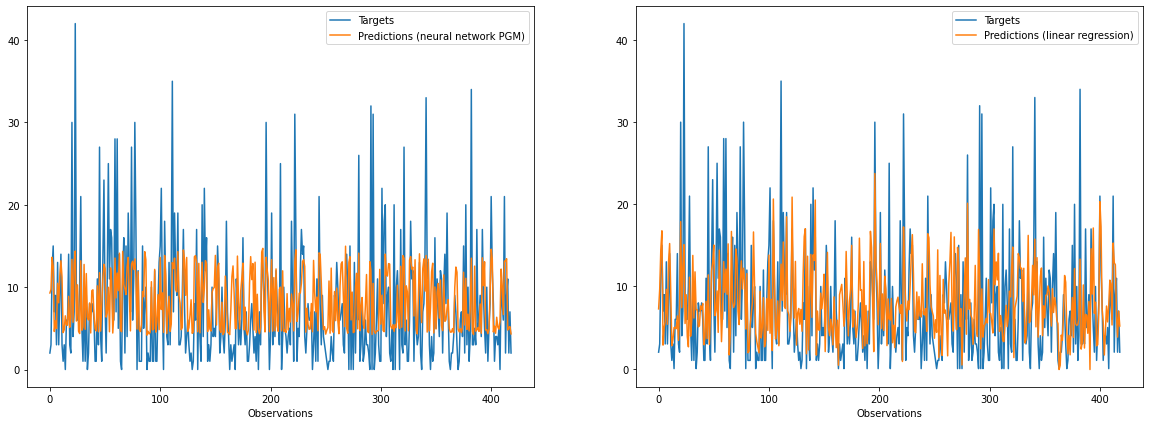

In [118]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat, label="Predictions (neural network PGM)")
ax[0].legend()
ax[0].set_xlabel("Observations")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)")
ax[1].legend()
ax[1].set_xlabel("Observations")
plt.show()

[]

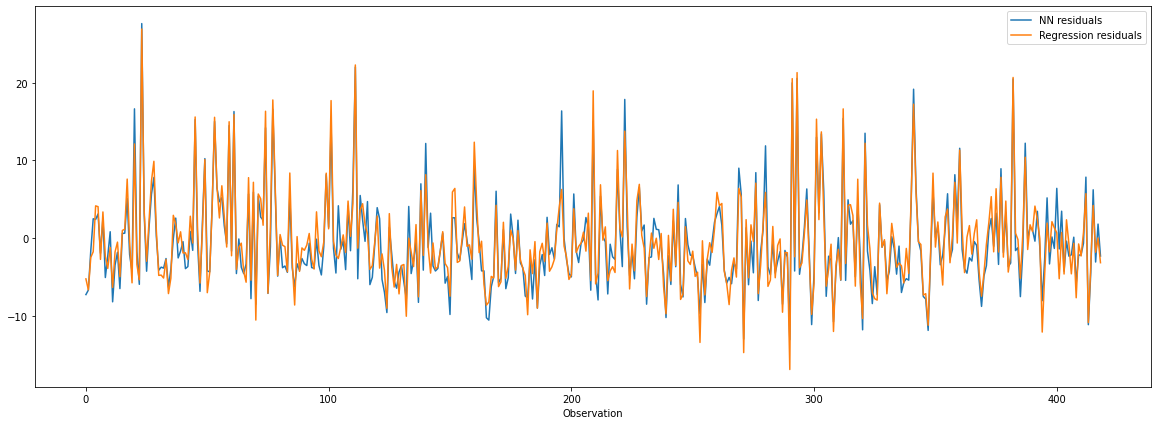

In [119]:
fig, ax = plt.subplots(1,1, figsize=(20,7))

ax.plot(y_test-y_hat, label="NN residuals")
ax.plot(y_test-y_hat_lreg, label="Regression residuals")
ax.legend()
ax.set_xlabel("Observation")
plt.plot()